In [1]:
from __future__ import division, print_function

import netCDF4 as nc
import numpy as np

from scipy.interpolate import griddata

import numpy.ma as ma
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import glob
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
from mpl_toolkits import basemap
import warnings
from exceptions import KeyError
from netCDF4 import Dataset
%matplotlib inline

In [2]:
#state locations of output
control = '/mnt/storage0/xhu/NEMO/ANHA4-EXH005/ANHA4-EXH005_'
control_storage = '/mnt/storage0/jacquielee/research/data/ANHA4-EXH005/ANHA4-EXH005_'
stlandj = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT002/ANHA4-VJT002_'
polzin  = '/mnt/storage0/jacquielee/research/data/ANHA4-VJT003/ANHA4-VJT003_'

In [3]:
mesh = nc.Dataset('/mnt/storage0/jacquielee/research/data/Jasper/mesh_mask_anha4_201509.nc')
mask = mesh.variables['tmask'][0]
mbathy = ma.array(mesh.variables['mbathy'][0],mask=(mask[0,:,:]-1)*-1)

In [4]:
mbathy.shape

(800, 544)

In [5]:
H=mesh.variables['gdept_0'][0]
lat=mesh.variables['nav_lat']
lon=mesh.variables['nav_lon']
e1t= mesh.variables['e1t'][0,:,:]  # dx
e2t= mesh.variables['e2t'][0,:,:]  # dy 
e3t= mesh.variables['e3t'][0,:,:,:]
volume=e1t*e2t*e3t
volume_density = (volume / np.sum(volume))*100

In [6]:
#pkappatidal = ma.array(nc.Dataset(polzin+'2012-2016avg_votkeavtidal.nc').variables['votkeavtidalfour'],mask=(mask-1)*-1)
#sjkappatidal = ma.array(nc.Dataset(stlandj+'2012-2016avg_votkeavtidal.nc').variables['votkeavtidalfour'],mask=(mask-1)*-1)


In [12]:
np.set_printoptions(suppress=True)
print(H[:40])

[    0.49402537     1.54137544     2.64566855     3.81949484     5.07822353
     6.440614       7.92956029     9.57299723    11.40500287    13.46713814
    15.81007331    18.49555958    21.59881546    25.21140882    29.44472894
    34.43415624    40.3440502     47.37368756    55.7642891     65.80727224
    77.85385106    92.32606906   109.7292808    130.66598418   155.85072861
   186.12556728   222.47516907   266.04024908   318.12742659   380.21302111
   453.93774517   541.08890874   643.56684341   763.33305097   902.33931191
  1062.43972124  1245.29111236  1452.25093765  1684.28440079  1941.89340079]


In [8]:
# Exy = np.zeros_like(pkappatidal)
# for kk in range(0,50):
#     Exy[kk,:,:] = E[:,:]
    
# Exy = ma.array(Exy,mask=(mask-1)*-1)

In [6]:
ckappa = ma.array(nc.Dataset(control_storage+'2012-2016avg_votkeavt.nc').variables['votkeavtfour'],mask=(mask-1)*-1)
pkappa = ma.array(nc.Dataset(polzin+'2012-2016avg_votkeavt.nc').variables['votkeavtfour'],mask=(mask-1)*-1)
sjkappa = ma.array(nc.Dataset(stlandj+'2012-2016avg_votkeavt.nc').variables['votkeavtfour'],mask=(mask-1)*-1)

In [9]:
# cnsq = ma.array(nc.Dataset(control_storage+'2012-2016avg_nsquare.nc').variables['nsquarefour'],mask=(mask-1)*-1)
# pnsq = ma.array(nc.Dataset(polzin+'2012-2016avg_nsquare.nc').variables['nsquarefour'],mask=(mask-1)*-1)
# sjnsq = ma.array(nc.Dataset(stlandj+'2012-2016avg_nsquare.nc').variables['nsquarefour'],mask=(mask-1)*-1)

In [7]:
def depth_from_bottom(var,depth):
    '''
    params are the 3D variable and the depth of grid cells
    returns the 3D depth from bottom variable and the new 3D grid for DFB metric
    and the furthest from bottom value.
    '''
    
    dfb_var = np.zeros_like(var)
    #dfb = np.zeros_like(var)
    DFB = np.zeros((len(var[0,:,0]),len(var[0,0,:])))
    for ii in np.arange(0,len(var[0,:,0])):
        for jj in np.arange(0,len(var[0,0,:])):
            dfbcount = 0
            for kk in np.arange(len(var[:,0,0])-1,-1,-1):
                if ma.is_masked(var[kk,ii,jj]):
                    continue
                    
                else:
                    dfb_var[dfbcount,ii,jj] = var[kk,ii,jj]
                    if dfbcount == 0:
#                        dfb[kk,ii,jj] = 0.0
                        DFB[ii,jj] = depth[kk]
#                     else: 
#                         dfb[dfbcount,ii,jj] = DFB[ii,jj]-depth[kk]
                    dfbcount = dfbcount+1
                    
                    
    print('completed')
    return dfb_var,DFB
                    
    
def DFB_log_avg(var,H,minimum):
    '''
    Variable is 3D and converted to depth from bottom
    DFB is a 2D grid with the depth of the water column
    
    For kappa want to remove values higher than 10**-2
    
    Want to average across similar depths. 
    Specify how many categories the results should be divided into
    '''

    var_new = np.zeros((len(H)))

    for k in np.arange(0,len(var[:,0,0])):
        counter = 0.0
        tot = 0.0

        for i in np.arange(0,len(var[0,:,0])):
            for j in np.arange(0,len(var[0,0,:])):
                
                if DFB[i, j] > minimum:
                
                    if ma.is_masked(var[k,i,j]) == False and var[k,i,j]<=10**-2:
                        counter = counter+1
                        tot = tot + np.log(var[k,i,j])        
                                

        if counter!= 0.0:
            var_new[k] = np.exp(tot/counter)
#             print(var_new[k],'kappa value')
#             print(counter, 'counter')
#             print(tot,'tot')
            
            
    print('logmean complete')
            
    return var_new
def DFB_arith_avg(var,DFB):
    '''
    Variable is 3D and converted to depth from bottom
    DFB is a 2D grid with the depth of the water column
    
    For kappa want to remove values higher than 10**-2
    
    Want to average across similar depths. 
    Specify how many categories the results should be divided into
    '''

    var_new = np.zeros((len(var[:,0,0])))

    for k in np.arange(0,len(var[:,0,0])):
        counter = 0.0
        tot = 0.0

        for i in np.arange(0,len(var[0,:,0])):
            for j in np.arange(0,len(var[0,0,:])):
                
                #if DFB[i, j] > minimum:
                
                if ma.is_masked(var[k,i,j]) == False:
                    counter = counter+1
                    tot = tot + var[k,i,j]

        if counter!= 0:
            var_new[k] = tot/counter
            print(var_new[k],'kappa value')
            print(counter, 'counter')
            print(tot,'tot')
    print('arithmean complete')
            
    return var_new

In [12]:
#First need to change the grid cell to be uniform
#Will set to 1m ? intervals. 
#If one grid cell goes over several intervals then it will have the same value for several 1m spots
#If a 1m spot falls inbetween two cells, then the arithmetic average will be taken
np.set_printoptions(suppress=True)
# print(H)
newH = np.arange(1,4500,75)
# print(newH)
#testcol = ckappa[:,700,200]
# print(testcol)

# newtestcol = griddata(H,testcol,newH)
# newtestcol = ma.masked_where(newtestcol[:]>10**-2,newtestcol[:])

# print(newtestcol)

In [14]:
#okay so using griddata and interpolating to a 1M constant z seems to work. 
#Just lose some variability in the surface. 
#So to calculate DFB regrid to 1m
#then log average this new grid
def interpolate_depth(var,H,newH):
    newvar = np.zeros((len(newH[:]),len(var[0,:,0]),len(var[0,0,:])))
    for i in np.arange(0,len(var[0,:,0])):
        for j in np.arange(0,len(var[0,0,:])):
            newvar[:,i,j] = griddata(H,var[:,i,j],newH)
            
    newvar = ma.masked_where(newvar[:,:,:] >10**-2, newvar)
    print('interpolation complete')
    return newvar
            


In [15]:
#look at either Arctic 400: or north atlantic :400
ckappanew = interpolate_depth(ckappa[:,:400,:], H, newH)
sjkappanew = interpolate_depth(sjkappa[:,:400,:], H, newH)
pkappanew = interpolate_depth(pkappa[:,:400,:], H, newH)

interpolation complete
interpolation complete
interpolation complete


In [18]:
#Find the DFB field (i.e. squash the kappa field) and dump a numpy file of the data 
#to avoid memory problems later on
DFBckap,DFB = depth_from_bottom(ckappanew,newH)
DFBckap.dump('/mnt/storage0/jacquielee/data/DFBckapATLANTIC.npy')
DFB.dump('/mnt/storage0/jacquielee/data/DFBATLANTIC.npy')
DFBsjkap,DFB = depth_from_bottom(sjkappanew,newH)
DFBsjkap.dump('/mnt/storage0/jacquielee/data/DFBsjkapATLANTIC.npy')

DFBpkap, DFB= depth_from_bottom(pkappanew,newH)
DFBpkap.dump('/mnt/storage0/jacquielee/data/DFBpkapATLANTIC.npy')


completed
completed
completed


In [8]:
DFBckap = np.load('/mnt/storage0/jacquielee/data/DFBckap.npy')
DFBsjkap = np.load('/mnt/storage0/jacquielee/data/DFBsjkap.npy')
DFBpkap = np.load('/mnt/storage0/jacquielee/data/DFBpkap.npy')
DFB = np.load('/mnt/storage0/jacquielee/data/DFB.npy')

In [21]:
DFBckap = ma.masked_where(DFBckap<10**-7,DFBckap)
DFBsjkap = ma.masked_where(DFBsjkap<10**-7,DFBsjkap)
DFBpkap = ma.masked_where(DFBpkap<10**-7,DFBpkap)

In [22]:
#now take the log average for all shallow profiles (less than 1000m)
clogkappa = DFB_log_avg(DFBckap,newH,1000)
clogkappa.dump('/mnt/storage0/jacquielee/data/clogkappafinegrid_<1000.npy')

sjlogkappa = DFB_log_avg(DFBsjkap,newH,1000)
sjlogkappa.dump('/mnt/storage0/jacquielee/data/sjlogkappafinegrid_<1000.npy')

plogkappa = DFB_log_avg(DFBpkap,newH,1000)
plogkappa.dump('/mnt/storage0/jacquielee/data/plogkappafinegrid_<1000.npy')

logmean complete
logmean complete
logmean complete


In [22]:
clogkappa = np.load('/mnt/storage0/jacquielee/data/clogkappa_2000.npy')
sjlogkappa = np.load('/mnt/storage0/jacquielee/data/sjlogkappa_2000.npy')
plogkappa = np.load('/mnt/storage0/jacquielee/data/plogkappa_2000.npy')

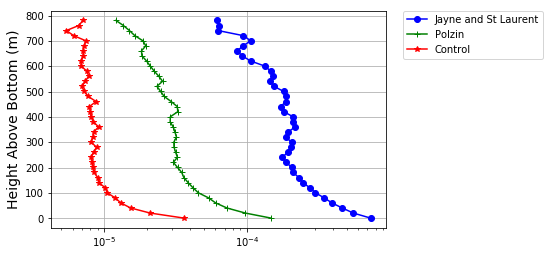

In [29]:

plt.plot(sjlogkappa[:40],newH[:40],marker='o',color='blue')
plt.plot(plogkappa[:40],newH[:40],marker='+',color='green')
plt.plot(clogkappa[:40],newH[:40],marker='*',color='red')
plt.legend([ 'Jayne and St Laurent','Polzin','Control'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale('log')
plt.ylabel('Height Above Bottom (m)',fontsize=14)

plt.grid()

In [3]:
# Fzp1 = np.multiply(pkappatidal,pnsq)
# Fzp2 = (const*Exy)
# Fzp = np.divide(Fzp1,Fzp2)

In [4]:
# Fzstl1 = np.multiply(sjkappatidal,sjnsq)
# Fzstl2 = const*Exy
# Fzstl = np.divide(Fzstl1,Fzstl2)

In [2]:
# nrows = 800
# ncols = 544
# nvert = 50
# path = polzin
# startyr = 2012
# var = 'Fz'

# netfile = Dataset(path+str(startyr)+'-'+str(startyr+4)+'avg_'+var+'.nc', 'w', format='NETCDF3_64BIT')
# print(path+str(startyr)+'-'+str(startyr+4)+'avg_'+var+'.nc')
    
# netfile.createDimension('x', nrows)
# netfile.createDimension('y', ncols)
# netfile.createDimension('z', nvert)
# new_var = netfile.createVariable(var+'four', 'f8', ('z','x', 'y'))
# new_var[:,:,:] = Fzp[:,:,:]
# netfile.close()

In [1]:
# Fzp = ma.array(nc.Dataset(polzin+'2012-2016avg_Fz.nc').variables['Fzfour'],mask=(mask-1)*-1)
# Fzstl = ma.array(nc.Dataset(stlandj+'2012-2016avg_Fz.nc').variables['Fzfour'],mask=(mask-1)*-1)

In [ ]:
def glob_arith_mean(var, kappa = False):
    var = var.flatten()
    vol = volume.flatten()
    var_new = 0.0
    counter = 0
    tot = 0.0
    
    for ii in np.arange(0,len(var)):
        
        if kappa == True:
            if ma.is_masked(var[ii]) == False and var[ii]<=10**-2: 
                counter = counter+vol[ii]
                tot = tot+var[ii]*vol[ii]
        else:
            counter = counter+vol[ii]
            tot = tot+var[ii]*vol[ii]
    var_new = tot/counter
    
    return var_new
def arith_mean(var, kappa=False):
    var_new = np.zeros((50))

    for k in np.arange(0,len(var[:,0,0])):
        print(k)
        counter = 0.0
        tot = 0.0

        for i in np.arange(0,len(var[0,:,0])):
            for j in np.arange(0,len(var[0,0,:])):
                
                if kappa == True:
                    if ma.is_masked(var[k,i,j]) == False and var[k,i,j]<=10**-2:
                            counter = counter+volume[k,i,j]
                            tot = tot + var[k,i,j]*volume[k,i,j]
                else:
                    if ma.is_masked(var[k,i,j]) == False:
                            counter = counter+volume[k,i,j]
                            tot = tot + var[k,i,j]*volume[k,i,j]

        if counter!= 0:
            var_new[k] = tot/counter
            
    return var_new
def log_mean(var,kappa=False):

    var_new = np.zeros((50))

    for k in np.arange(0,len(var[:,0,0])):
        print(k)
        counter = 0.0
        tot = 0.0

        for i in np.arange(0,len(var[0,:,0])):
            for j in np.arange(0,len(var[0,0,:])):
                
                if kappa == True:
                    if ma.is_masked(var[k,i,j]) == False and var[k,i,j]<=10**-2:
                            counter = counter+volume[k,i,j]
                            tot = tot + np.log(var[k,i,j])*volume[k,i,j]
                else:
                    if ma.is_masked(var[k,i,j]) == False:
                            counter = counter+volume[k,i,j]
                            tot = tot + np.log(var[k,i,j])*volume[k,i,j]

        if counter!= 0:
            var_new[k] = np.exp(tot/counter)
            
    return var_new

In [5]:
#Fzp_glob = log_mean(Fzp)
#Fzstl_glob = arith_mean(Fzstl)

In [7]:
# plt.plot(Fzp_glob[:],H)
# #plt.plot(Fzstl[:,100,250],H)
# plt.xscale('log')
# plt.legend([ 'polzin','Stl'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.ylim(H[-1],H[0])
# plt.show()

In [6]:
#Fzp_glob